### Mount Drive and import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
data= pd.read_csv("/content/drive/MyDrive/Anamoly_Detection/forestfires.csv")

### Introduction to Dataset

In [3]:
data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [4]:
data.month = pd.to_datetime(data.month, format='%b').dt.month
data = data.drop(columns="day")
data['index'] = range(1, len(data) + 1)

#### Understanding the Data

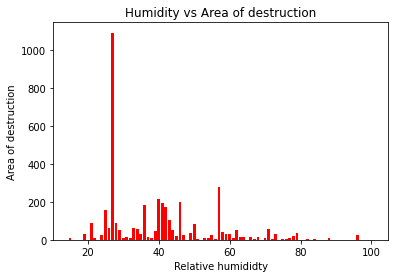

In [5]:
import matplotlib.pyplot as plt
X = data['RH']
Y = data['area']

plt.bar(X, Y, color = ['red'])
 
plt.xlabel('Relative humididty')
plt.ylabel('Area of destruction')
plt.title('Humidity vs Area of destruction')
plt.show()

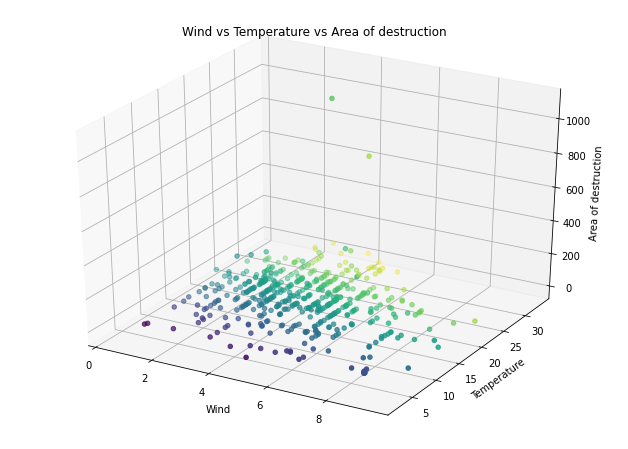

In [6]:
fig = plt.figure()
fig.set_figwidth(11)
fig.set_figheight(8)
ax = plt.axes(projection ='3d')

X = data['wind']
Y = data['temp']
Z = data['area']
color = X + Y
ax.scatter(X, Y, Z, c = color)
plt.xlabel('Wind')
plt.ylabel('Temperature')
ax.set_zlabel('Area of destruction')
ax.set_title('Wind vs Temperature vs Area of destruction')
plt.show()


{'boxes': [<matplotlib.lines.Line2D at 0x7fdb76aa5250>],
 'caps': [<matplotlib.lines.Line2D at 0x7fdb76aae2d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdb76ab6310>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fdb76aaed90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fdb76aa5810>,
  <matplotlib.lines.Line2D at 0x7fdb76aa5d50>]}

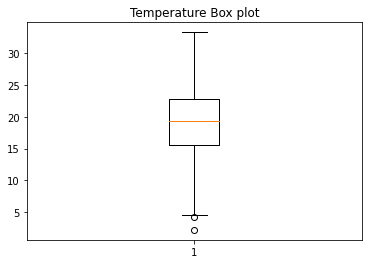

In [7]:
fig1, ax1 = plt.subplots()
ax1.set_title('Temperature Box plot')
ax1.boxplot(data['temp'])

### Model Training and Prediction

Initial Prediction

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X_train, X_test, Y_train, Y_test = train_test_split(data, data[['area']], test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(346, 13) (171, 13) (346, 1) (171, 1)


In [9]:
LR_model = LinearRegression()
LR_model.fit(X_train, Y_train)
pred = LR_model.predict(X_test)
initial_error = mean_absolute_error(Y_test, pred)

print(initial_error)

9.78059540433371e-13


### Anamoly Detection Methods

#### 1. Isolation Forest


>  Isolation Forest is based on Decision trees and is an unsupervised model.
>  In an Isolation Forest, randomly sub-sampled data is processed in a tree structure based on randomly selected features. The samples that travel deeper into the tree are less likely to be anomalies as they required more cuts to isolate them. Similarly, the samples which end up in shorter branches indicate anomalies as it was easier for the tree to separate them from other observations.





Outlier Dectection in Temperature Data

In [10]:
from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(contamination=0.1)
pred = iso_model.fit_predict(data[['temp']].values)

In [11]:
data['iso_temp'] = iso_model.predict(data[['temp']].values) #isolation forest returns -1 for outlier tempertaure values
data[data['iso_temp']==-1].head() #lets display only the outliers

,X,Y,month,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,index,iso_temp
0,7,5,3,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,-1
3,8,6,3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,4,-1
7,8,6,8,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0,8,-1
19,6,4,4,86.3,27.4,97.1,5.1,9.3,44,4.5,0.0,0.0,20,-1
28,6,3,9,93.4,145.4,721.4,8.1,30.2,24,2.7,0.0,0.0,29,-1


Graph to display the outliers

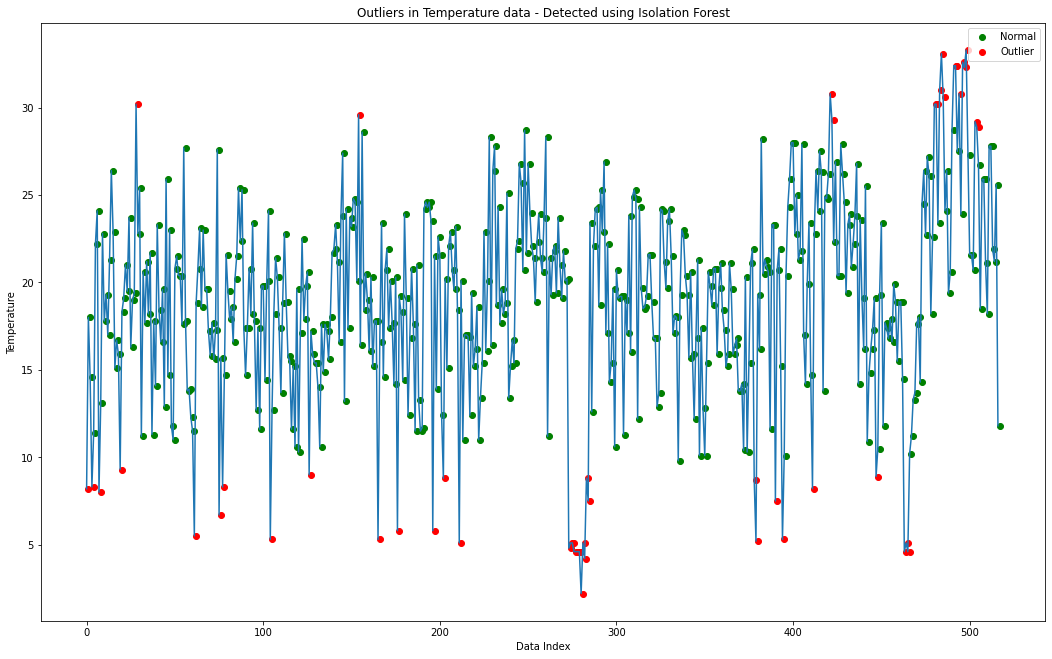

In [21]:
plt.figure(2)
plt.rcParams["figure.figsize"] = (18,11)

plt.xlabel('Data Index')
plt.ylabel('Temperature')
plt.title('Outliers in Temperature data - Detected using Isolation Forest')

plt.plot(data['temp'])
plt.scatter(data.values[data['iso_temp'] == 1, 12], data.values[data['iso_temp'] == 1, 7], c = 'green', label = 'Normal')
plt.scatter(data.values[data['iso_temp'] == -1, 12], data.values[data['iso_temp'] == -1, 7], c = 'red', label = 'Outlier')
plt.legend()

Lets see how the Regression model performs after removing the outliers 

In [13]:
pred = iso_model.fit_predict(X_train.values)
mask = pred != -1
outliers = pred == -1

x_train, y_train = X_train.values[mask,:], Y_train[mask]
iso_outliers = X_train.shape[0] - x_train.shape[0] 
print('Number of ouliers removed using Isolation Forest: ', iso_outliers)
print('Training data after removing the outliers: ', x_train.shape, y_train.shape)

Number of ouliers removed using Isolation Forest:  35
Training data after removing the outliers:  (311, 13) (311, 1)


In [14]:
LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
pred = LR_model.predict(X_test.values)

iso_error = mean_absolute_error(Y_test, pred)
print('Mean absolute error after removing outlier:', iso_error)

Mean absolute error after removing outlier: 2.4477259665336415e-14


#### 2. Local Outlier Factor


> Local Outlier Factor is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

In [15]:
from sklearn.neighbors import LocalOutlierFactor

LOF_model = LocalOutlierFactor()
pred = LOF_model.fit_predict(X_train)

mask = pred != -1

x_train, y_train = X_train.values[mask,:], Y_train[mask] 
lof_outliers = X_train.shape[0] - x_train.shape[0] 
print('Number of ouliers removed using Local Outlier Factor', lof_outliers)
print('Training data after removing the outliers: ', x_train.shape, y_train.shape)

Number of ouliers removed using Local Outlier Factor 10
Training data after removing the outliers:  (336, 13) (336, 1)


Lets see how the Regression model performs after removing the outliers

In [16]:
LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
pred = LR_model.predict(X_test.values)

lof_error = mean_absolute_error(Y_test, pred)
print('Mean absolute error after removing outlier:', lof_error)

Mean absolute error after removing outlier: 4.0443895162667765e-14


#### 3. One class SVM

> One-class SVM is a variation of the SVM that can be used in an unsupervised setting for anomaly detection.Recall that a regular SVM for classification finds a max-margin hyperplane that seperates the positive examples from the negative ones. The one-class SVM finds a hyper-plane that separates the given dataset from the origin such that the hyperplane is as close to the datapoints as possible.





In [17]:
from sklearn.svm import OneClassSVM
svm_model = OneClassSVM(nu=0.01)
pred = svm_model.fit_predict(X_train)
mask = pred != -1

x_train, y_train = X_train.values[mask,:], Y_train[mask] 
svm_outliers = X_train.shape[0] - x_train.shape[0] 
print('Number of ouliers removed using One Class SVM: ', svm_outliers)
print('Training data after removing the outliers: ', x_train.shape, y_train.shape)

Number of ouliers removed using One Class SVM:  3
Training data after removing the outliers:  (343, 13) (343, 1)


Lets see how the Regression model performs after removing the outliers

In [18]:
LR_model = LinearRegression()
LR_model.fit(x_train, y_train)
pred = LR_model.predict(X_test.values)

svm_error = mean_absolute_error(Y_test, pred)
print('Mean absolute error after removing outlier:', svm_error)

Mean absolute error after removing outlier: 2.505853852203336e-14


### Performance evalution of Outlier Detection methods

> We can observe that Isolation forest has detected more number of anomalies than Local outlier factor and One class SVM methods. Although the Mean absolute error obtained by One class SVM is not much higher than the error obtained by the Isolation forest method, the latter has the least error among the three anomaly detection methods.

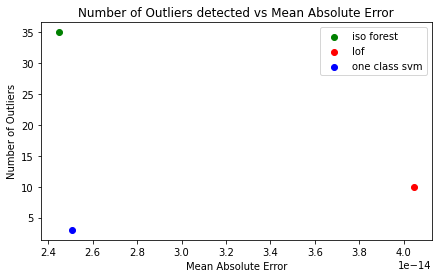

In [23]:
plt.figure(2)
plt.rcParams["figure.figsize"] = (7,4)
plt.xlabel('Mean Absolute Error')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers detected vs Mean Absolute Error')

plt.scatter(iso_error, iso_outliers, color = ['green'], label='iso forest')
plt.scatter(lof_error, lof_outliers, color = ['red'], label='lof')
plt.scatter(svm_error, svm_outliers, color = ['blue'], label='one class svm')
plt.legend()